In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import copy
from sklearn import metrics
from statistics import mean , stdev
from pprint import pprint
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
import pickle

In [6]:
def data_preprocessing():
    
    global train_sd, train_mean
    
    df = pd.read_csv("apparel-trainval.csv")
    
    X = df.iloc[:,1:]
    Y = df.iloc[:,0]
    

    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 0)
    
    Y_train = pd.DataFrame(Y_train)
    Y_train = Y_train.values
    
    Y_validation = pd.DataFrame(Y_validation)
    Y_validation = Y_validation.values
    
    
    X_train = X_train.values
    X_validation = X_validation.values
    
    train_sd = np.std(X_train)
    train_mean = np.mean(X_train)

    X_train = (X_train - train_mean)/train_sd
    X_validation = (X_validation - train_mean)/train_sd

    
    return X_train, X_validation, Y_train, Y_validation 

In [7]:
class neural_layer:
    
    def __init__(self,weight,bias):
        
        self.weight = weight
        self.bias = bias
        self.activations = None
        self.delta = None

In [8]:
class Neural_Network:
    
    def __init__(self, layer_sizes = None, activation_function = None,mode = "training"):
        
        if mode == "training": 
            
            self.layer_sizes = layer_sizes
            self.activation_function = activation_function
            
            network_layer = []

            for index in range(len(layer_sizes)-1):

                weight = np.random.randn(layer_sizes[index],layer_sizes[index+1])*np.sqrt(2.0/layer_sizes[index])
                bias = np.random.randn(layer_sizes[index+1],1)

                layer = neural_layer(weight,bias)

                network_layer.append(layer)

            self.network_layer = network_layer
        
        elif mode == "testing":
            
            network_layer = None
            
            with open ('model', 'rb') as fp:
                network_layer = pickle.load(fp)
            
            self.layer_sizes = network_layer[0]
            self.activation_function = network_layer[1]
            self.network_layer = network_layer[2]
            
    def fit(self, data, Y, n_iterations, learning_rate):
        
        batch_size = 100
        
        self.error_per_epoch = []
        self.epochs = []
        
        for iteration in range(n_iterations):
        
#             print("Iterations: ",iteration)
            
            batches = math.floor(data.shape[0]/batch_size)
            
            error = 0
            start = 0
            end = batch_size
        
            for batch in range(batches):

                X = data[start:end,:]

                y = Y[start:end,:]

                start += batch_size
                end += batch_size

                if end > data.shape[0]:
                    end = data.shape[0]


            
                #forward propagation
                index = 0
                for layer in self.network_layer:
                    
                    if index == 0:
                        
                        layer.activations = self.nl_transform(X,layer.weight,layer.bias,self.activation_function[index]) 
                    
                    elif index == len(self.network_layer) - 1:
                        
                        layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])
                        self.output_layer = layer.activations
                    
                    else:
                    
                        layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])

                    index += 1


                #backward propagation
                for index, layer in reversed(list(enumerate(self.network_layer))):

                    if index == len(self.network_layer) - 1:    

                        layer.delta = self.cross_entropy_error_derivative(y , layer.activations) * self.nl_derivative(layer.activations,self.activation_function[index])

                    else:
                        
                        layer.delta = np.dot(self.network_layer[index+1].delta,self.network_layer[index+1].weight.T) * self.nl_derivative(layer.activations,self.activation_function[index])

                #weight and bias update
                for index, layer in reversed(list(enumerate(self.network_layer))):

                    if index == 0:
                        
                        layer.weight -= (learning_rate/batch_size) * np.dot(X.T,layer.delta)
                    
                    else:
                    
                        layer.weight -= (learning_rate/batch_size) * np.dot(self.network_layer[index - 1].activations.T,layer.delta)

                    bias_gradient = pd.DataFrame(np.sum(layer.delta, axis=0)).values * (learning_rate/batch_size)                    
                    layer.bias -= bias_gradient
                
                
            
                    error = self.cross_entropy_error(self.output_layer,y)
                
            self.error_per_epoch.append(round(error,3))
            
            self.epochs.append(iteration+1)
            

        self.dump_model()
                    
    def cross_entropy_error(self,y_predicted,y_actual):
        
        error = -np.sum(y_actual*np.log(y_predicted+1e-9))/(y_actual.shape[0])
        
        return error
            
    def dump_model(self):
        
        global train_sd, train_mean
        
        neural_net_model = []
        neural_net_model.append(self.layer_sizes)
        neural_net_model.append(self.activation_function)
        neural_net_model.append(self.network_layer)
        neural_net_model.append(train_mean)
        neural_net_model.append(train_sd)
        
        with open('model', 'wb') as fp:
            pickle.dump(neural_net_model, fp)
            
    def predict(self, X):

        index = 0
        
        for layer in self.network_layer:
            
            if index == 0:
                
                layer.activations = self.nl_transform(X,layer.weight,layer.bias,self.activation_function[index]) 
            
            elif index == len(self.network_layer) - 1:
                
                layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])
                final_activation = layer.activations
            
            else:
                layer.activations = self.nl_transform(self.network_layer[index-1].activations,layer.weight,layer.bias,self.activation_function[index])

            index += 1

        y_predicted = []
        
        self.predicted = final_activation
        
        for row in final_activation:
            
#             e_x = np.exp(row - np.max(row))
#             softmax =  e_x / e_x.sum()

            y_predicted.append(np.argmax(row))
        
        return y_predicted 
    
    def cross_entropy_error_derivative(self,y_actual,y_predicted):
        
        return np.nan_to_num(-((y_actual / y_predicted) - ((1 - y_actual) / (1 - y_predicted))))
    
    def nl_derivative(self,activations,activation_function):
        
        if activation_function == "sigmoid":
            
            return self.sigmoid_derivative(activations)
            
        elif activation_function == "relu":
            
            return self.relu_derivative(activations)
            
        elif activation_function == "tanh":
            
            return self.tanh_derivative(activations)
    
    def nl_transform(self,X,Y,B,activation_function):
        
        x = np.dot(X,Y) + B.T
        
        if activation_function == "sigmoid":
            
            return self.sigmoid(x)
            
        elif activation_function == "relu":
            
            return self.relu(x)
            
        elif activation_function == "tanh":
            
            return self.tanh(x)
            
    def sigmoid(self, x):
        
        result = np.nan_to_num(1.0 / (1.0 + np.exp(-x)))
        return result
    
    def tanh(self, x):
        
        result = np.nan_to_num(2.0/(1.0 + np.exp(-(2*x))) - 1)
        return result

    def relu(self,x):
        
        return np.nan_to_num(x * (x > 0))

    def tanh_derivative(self, x):
        
        result = np.nan_to_num(1 - np.tanh(x)**2)
        
        return result    
    
    def sigmoid_derivative(self, x):
        
        result = np.nan_to_num((x)*(1-x))
        
        return result    
        
    def relu_derivative(self, x):
        
        return np.nan_to_num(1 * (x > 0))

In [9]:
def generate_confusion_matrix(y_actual,y_predicted):
    
    confusion_matrix = metrics.cluster.contingency_matrix(y_actual, y_predicted)
    
    return confusion_matrix 

In [10]:
def calculate_accuracy(y_actual,y_predicted):
    
    confusion_matrix = generate_confusion_matrix(y_actual,y_predicted)
    
#     print(confusion_matrix)
    
    return np.sum(np.amax(confusion_matrix, axis=0))/np.sum(confusion_matrix)

In [11]:
def cross_entropy_error(y_actual,y_predicted):
        
        error = -np.sum(y_actual*np.log(y_predicted+1e-9))/(y_actual.shape[0])
        
        return error

In [12]:
def layer_vs_prediction_error():
    
    X_train, X_validation, Y_train, Y_validation = data_preprocessing()
    
    layers = [X_train.shape[1]]
    act_func = ['sigmoid']
    
    nb_classes = 10
    targets = Y_train.reshape(-1)
    y_hot = np.eye(nb_classes)[targets]
    
    targets_val = Y_validation.reshape(-1)
    y_hot_val = np.eye(nb_classes)[targets_val]
    
    error_train = []
    error_validate = []
    n_layer = []
    
    for i in range(5):
        
        n_layer.append(i+1)
        
        layers.append(100)
        layers.append(10)
        
        act_func.append('sigmoid')
        
        nl_obj = Neural_Network(layer_sizes = layers, activation_function = act_func,mode = "training")

        nl_obj.fit(X_train,y_hot,10,0.15)
        

        y_predicted = nl_obj.predict(X_train)
        
        err = cross_entropy_error(y_hot,nl_obj.predicted)
        print("Precidtion Error on Train data: ",err)
        error_train.append(err)
        
        y_predicted = nl_obj.predict(X_validation)
        
        err = cross_entropy_error(y_hot_val,nl_obj.predicted)
        print("Precidtion Error on Validation data: ",err)
        error_validate.append(err)
        
        layers = layers[:-1]
    
    error_vs_layer_df = pd.DataFrame(
    {'Train Data': error_train,
     'Validation Data': error_validate,
     'Layers': n_layer
    })
    
    
    error_vs_layer_df = error_vs_layer_df.melt('Layers', var_name='Data',  value_name='Prediction Error')
    error_vs_layer_graph = sns.factorplot(x="Layers", y="Prediction Error", hue='Data', data=error_vs_layer_df)
    
    error_vs_layer_graph.savefig("error_vs_layer_graph.png")

Precidtion Error on Train data:  0.326107150836468
Precidtion Error on Validation data:  0.36649472632031665
Precidtion Error on Train data:  0.33575645874025
Precidtion Error on Validation data:  0.37464789670849835
Precidtion Error on Train data:  0.34161813032066446
Precidtion Error on Validation data:  0.38204021107891506
Precidtion Error on Train data:  0.36753159343670905
Precidtion Error on Validation data:  0.40392790688046115
Precidtion Error on Train data:  0.5203768351710503
Precidtion Error on Validation data:  0.5597997223532766


/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


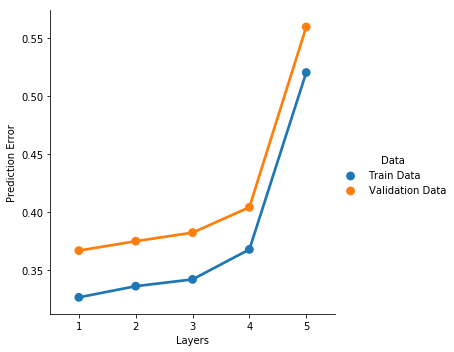

In [72]:
layer_vs_prediction_error()

In [13]:
def epoch_vs_prediction_error_activation_fuction():
    
    X_train, X_validation, Y_train, Y_validation = data_preprocessing()
    
    nb_classes = 10
    targets = Y_train.reshape(-1)
    y_hot = np.eye(nb_classes)[targets]
    
    targets_val = Y_validation.reshape(-1)
    y_hot_val = np.eye(nb_classes)[targets_val]
    
    epochs_list = [5,10,15,20,25,30]
    
    error_train_sigmoid = []
    error_validate_sigmoid = []
    
    error_train_relu = []
    error_validate_relu = []
    
    error_train_tanh = []
    error_validate_tanh = []
    
    for epoch in epochs_list:
       
        nl_obj_sigmoid = Neural_Network(layer_sizes = [X_train.shape[1],60,60,10], activation_function = ['sigmoid','sigmoid','sigmoid'],mode = "training")
        nl_obj_relu = Neural_Network(layer_sizes = [X_train.shape[1],60,60,10], activation_function = ['relu','relu','sigmoid'],mode = "training")
        nl_obj_tanh = Neural_Network(layer_sizes = [X_train.shape[1],60,60,10], activation_function = ['tanh','tanh','sigmoid'],mode = "training")
        
        
        nl_obj_sigmoid.fit(X_train,y_hot,epoch,0.15)
        nl_obj_relu.fit(X_train,y_hot,epoch,0.15)
        nl_obj_tanh.fit(X_train,y_hot,epoch,0.15)
        
        y_predicted_sigmoid = nl_obj_sigmoid.predict(X_train)
        y_predicted_relu = nl_obj_relu.predict(X_train)
        y_predicted_tanh = nl_obj_tanh.predict(X_train)
        
        err = cross_entropy_error(y_hot,nl_obj_sigmoid.predicted)
        print("Precidtion Error on Train data Sigmoid: ",err)
        error_train_sigmoid.append(err)
        
        err = cross_entropy_error(y_hot,nl_obj_relu.predicted)
        print("Precidtion Error on Train data Relu: ",err)
        error_train_relu.append(err)
        
        err = cross_entropy_error(y_hot,nl_obj_tanh.predicted)
        print("Precidtion Error on Train data tanh: ",err)
        error_train_tanh.append(err)
        
        
        y_predicted_sigmoid = nl_obj_sigmoid.predict(X_validation)
        y_predicted_relu = nl_obj_relu.predict(X_validation)
        y_predicted_tanh = nl_obj_tanh.predict(X_validation)
        
        err = cross_entropy_error(y_hot_val,nl_obj_sigmoid.predicted)
        print("Precidtion Error on Validation data Sigmoid: ",err)
        error_validate_sigmoid.append(err)
        
        err = cross_entropy_error(y_hot_val,nl_obj_relu.predicted)
        print("Precidtion Error on Validate data Relu: ",err)
        error_validate_relu.append(err)
        
        err = cross_entropy_error(y_hot_val,nl_obj_tanh.predicted)
        print("Precidtion Error on Validate data tanh: ",err)
        error_validate_tanh.append(err)
        
    error_vs_epoch_train_df = pd.DataFrame(
    {'Sigmoid': error_train_sigmoid,
     'Relu': error_train_relu,
     'Tanh': error_train_tanh,
     'Epochs': epochs_list
    })
    
    
    error_vs_epoch_train_df = error_vs_epoch_train_df.melt('Epochs', var_name='Activation Fuctions',  value_name='Prediction Error')
    error_vs_epoch_train_graph = sns.factorplot(x="Epochs", y="Prediction Error", hue='Activation Fuctions', data=error_vs_epoch_train_df)
    
    error_vs_epoch_train_graph.savefig("error_vs_epoch_train_graph.png")
    
    
    error_vs_epoch_validate_df = pd.DataFrame(
    {'Sigmoid': error_validate_sigmoid,
     'Relu': error_validate_relu,
     'Tanh': error_validate_tanh,
     'Epochs': epochs_list
    })
    
    
    error_vs_epoch_validate_df = error_vs_epoch_validate_df.melt('Epochs', var_name='Activation Fuctions',  value_name='Prediction Error')
    error_vs_epoch_validate_graph = sns.factorplot(x="Epochs", y="Prediction Error", hue='Activation Fuctions', data=error_vs_epoch_validate_df)

    error_vs_epoch_validate_graph.savefig("error_vs_epoch_validate_graph.png")
    
    

Precidtion Error on Train data Sigmoid:  0.40343224976543335
Precidtion Error on Train data Relu:  0.3417153601505965
Precidtion Error on Train data tanh:  0.3897547039011202
Precidtion Error on Validation data Sigmoid:  0.41960887936176605
Precidtion Error on Validate data Relu:  0.3888793553800871
Precidtion Error on Validate data tanh:  0.418315270769063
Precidtion Error on Train data Sigmoid:  0.33488487038845655
Precidtion Error on Train data Relu:  0.29527131860164546
Precidtion Error on Train data tanh:  0.35608884003144287
Precidtion Error on Validation data Sigmoid:  0.372364465959133
Precidtion Error on Validate data Relu:  0.3774616428944974
Precidtion Error on Validate data tanh:  0.4218722311230422


/usr/lib/python3/dist-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


Precidtion Error on Train data Sigmoid:  0.30452243798337286
Precidtion Error on Train data Relu:  0.2525109890152563
Precidtion Error on Train data tanh:  0.32969473125117676
Precidtion Error on Validation data Sigmoid:  0.3630069910529989
Precidtion Error on Validate data Relu:  0.3568352452603457
Precidtion Error on Validate data tanh:  0.40814486903554115
Precidtion Error on Train data Sigmoid:  0.28125568479384827
Precidtion Error on Train data Relu:  0.28482079826230383
Precidtion Error on Train data tanh:  0.3269424195398435
Precidtion Error on Validation data Sigmoid:  0.35661751672138264
Precidtion Error on Validate data Relu:  0.4344183081555068
Precidtion Error on Validate data tanh:  0.4166337051788555
Precidtion Error on Train data Sigmoid:  0.2596463369540521
Precidtion Error on Train data Relu:  0.26189046854641723
Precidtion Error on Train data tanh:  0.3135199370930874
Precidtion Error on Validation data Sigmoid:  0.35506417286873254
Precidtion Error on Validate data R

/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


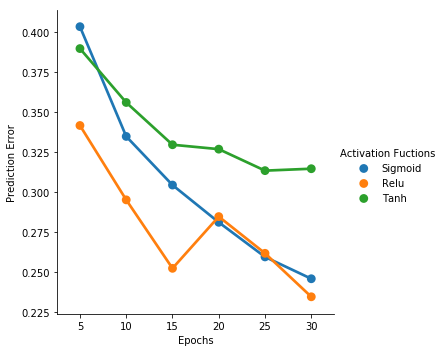

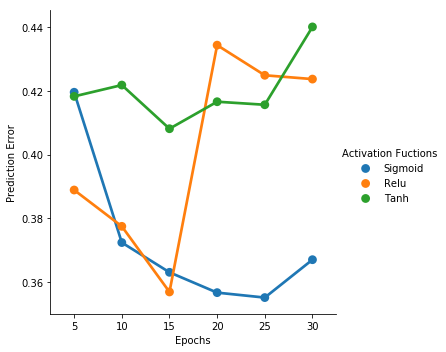

In [78]:
epoch_vs_prediction_error_activation_fuction()

In [14]:
def epoch_vs_accracy():
    
    X_train, X_validation, Y_train, Y_validation = data_preprocessing()
    
    nb_classes = 10
    targets = Y_train.reshape(-1)
    y_hot = np.eye(nb_classes)[targets]
    
    epochs_list = [5,10,15,20,25,30]
    
    accuracy_train = []
    accuracy_validate = []
    
    for epoch in epochs_list:
       
        nl_obj = Neural_Network(layer_sizes = [X_train.shape[1],60,60,10], activation_function = ['tanh','relu','sigmoid'],mode = "training")
        
        nl_obj.fit(X_train,y_hot,epoch,0.3)
        
        y_predicted = nl_obj.predict(X_train)
        
        acc = calculate_accuracy((Y_train.T).tolist()[0],y_predicted)
        print("Accuracy on Train data: ",acc)
        accuracy_train.append(acc)
        
        y_predicted = nl_obj.predict(X_validation)
        
        acc = calculate_accuracy((Y_validation.T).tolist()[0],y_predicted)
        print("Accuracy on Validation data: ",acc)
        accuracy_validate.append(acc)
        
    accuracy_vs_epochs_df = pd.DataFrame(
    {'Train Data': accuracy_train,
     'Validation Data': accuracy_validate,
     'Epochs': epochs_list
    })
    
    
    accuracy_vs_epochs_df = accuracy_vs_epochs_df.melt('Epochs', var_name='Data',  value_name='Accuracy')
    accuracy_vs_epochs_df_graph = sns.factorplot(x="Epochs", y="Accuracy", hue='Data', data=accuracy_vs_epochs_df)
    
    accuracy_vs_epochs_df_graph.savefig("accuracy_vs_epochs_graph.png")
    

Accuracy on Train data:  0.8829791666666666
Accuracy on Validation data:  0.8701666666666666
Accuracy on Train data:  0.8928541666666666
Accuracy on Validation data:  0.8738333333333334
Accuracy on Train data:  0.9004375
Accuracy on Validation data:  0.872
Accuracy on Train data:  0.9065
Accuracy on Validation data:  0.8781666666666667
Accuracy on Train data:  0.904375
Accuracy on Validation data:  0.8693333333333333
Accuracy on Train data:  0.9085416666666667
Accuracy on Validation data:  0.8675


/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


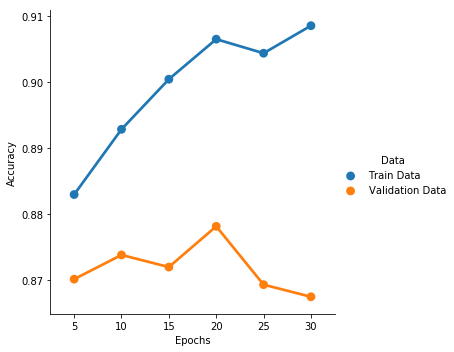

In [53]:
epoch_vs_accracy()

In [15]:
def layer_vs_accuracy_error():
    
    X_train, X_validation, Y_train, Y_validation = data_preprocessing()
    
    layers = [X_train.shape[1]]
    act_func = ['sigmoid']
    
    nb_classes = 10
    targets = Y_train.reshape(-1)
    y_hot = np.eye(nb_classes)[targets]
    
    accuracy = []
    n_layer = []
    
    for i in range(5):
        
        n_layer.append(i+1)
        
        layers.append(100)
        layers.append(10)
        
        act_func.append('sigmoid')
        
        nl_obj = Neural_Network(layer_sizes = layers, activation_function = act_func,mode = "training")

        nl_obj.fit(X_train,y_hot,10,0.15)
        y_predicted = nl_obj.predict(X_validation)
        
        acc = calculate_accuracy((Y_validation.T).tolist()[0],y_predicted)
        
        print("accuracy: ",acc)
        
        accuracy.append(acc)
        
        layers = layers[:-1]
    
    accuracy_vs_layers_df = pd.DataFrame(
    {'Accuracy': accuracy,
     'No. of Layers': n_layer
    })
    
    #Accuracy visualisation
    accuracy_vs_layers_df = accuracy_vs_layers_df.melt('Accuracy', value_name='No. of Layers')
    accuracy_vs_layers_graph = sns.factorplot(x="No. of Layers", y="Accuracy", data=accuracy_vs_layers_df)
    
    accuracy_vs_layers_graph.savefig("accuracy_vs_layers_graph.png")
    

accuracy:  0.8764166666666666
accuracy:  0.8778333333333334
accuracy:  0.8745
accuracy:  0.8554166666666667
accuracy:  0.8148333333333333


/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


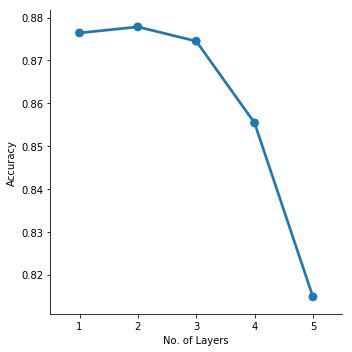

In [51]:
layer_vs_accuracy_error()

In [16]:
def evaluate():

    X_train, X_validation, Y_train, Y_validation = data_preprocessing()

    nl_obj = Neural_Network(layer_sizes = [X_train.shape[1],100,10], activation_function = ['relu','sigmoid'],mode = "training")

    nb_classes = 10
    
    targets = Y_train.reshape(-1)
    y_hot = np.eye(nb_classes)[targets]

    nl_obj.fit(X_train,y_hot,10,0.10)

    error_vs_epochs_df = pd.DataFrame(
    {'Epochs': nl_obj.epochs,
     'Error': nl_obj.error_per_epoch
    })
    
    #Accuracy visualisation
    error_vs_epochs_df = error_vs_epochs_df.melt('Error', value_name='Epochs')
    error_vs_epochs_graph = sns.factorplot(x="Epochs", y="Error", data=error_vs_epochs_df)
    
    error_vs_epochs_graph.savefig("error_vs_epochs_graph.png")
    
    y_predicted = nl_obj.predict(X_validation)
    print("accuracy: ",calculate_accuracy((Y_validation.T).tolist()[0],y_predicted))

#     nl_test = Neural_Network(layer_sizes = None, activation_function = None,mode = "testing")

#     y_predicted = nl_test.predict(X_validation)
#     print("accuracy: ",calculate_accuracy((Y_validation.T).tolist()[0],y_predicted))



/home/prakashjha/.local/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


accuracy:  0.88075


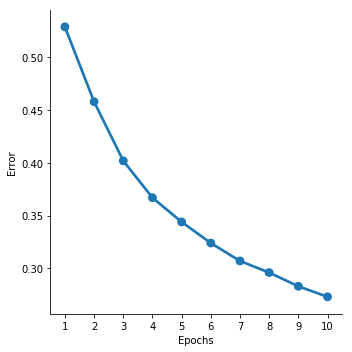

In [17]:
evaluate()

In [22]:
def evalaute_test_file():
    
    df = pd.read_csv("apparel-test.csv")
    
    X = df.values
    
    with open ('model', 'rb') as fp:
        network_layer = pickle.load(fp)
    
    mean = network_layer[3]
    sd = network_layer[4]
    
    X = (X - mean)/sd
    
    nl_test = Neural_Network(layer_sizes = None, activation_function = None,mode = "testing")

    y_predicted = nl_test.predict(X)
    
    print(y_predicted)
    
    with open('2018201013_prediction.csv', 'w') as f:
        for item in y_predicted:
            f.write("%s\n" % item)

In [23]:
evalaute_test_file()

[0, 1, 2, 2, 4, 6, 8, 2, 5, 0, 3, 2, 4, 6, 8, 5, 6, 3, 6, 4, 4, 4, 2, 1, 5, 7, 8, 4, 4, 1, 7, 7, 7, 8, 1, 0, 9, 8, 6, 8, 2, 0, 4, 4, 2, 0, 3, 3, 2, 3, 2, 6, 9, 3, 0, 9, 9, 4, 0, 3, 4, 5, 4, 6, 1, 1, 0, 9, 5, 2, 7, 3, 2, 2, 5, 7, 1, 6, 1, 3, 9, 8, 1, 6, 4, 8, 9, 4, 1, 6, 3, 6, 2, 2, 5, 0, 4, 7, 7, 3, 9, 6, 9, 8, 8, 2, 3, 8, 2, 7, 5, 5, 3, 2, 7, 5, 0, 2, 7, 4, 0, 5, 6, 4, 7, 0, 8, 5, 0, 3, 1, 7, 9, 4, 9, 6, 4, 2, 6, 4, 3, 3, 3, 2, 2, 6, 3, 0, 1, 3, 4, 3, 3, 1, 9, 3, 3, 3, 9, 5, 6, 7, 7, 3, 2, 4, 0, 6, 7, 2, 2, 8, 9, 0, 2, 4, 6, 5, 7, 9, 7, 1, 3, 9, 1, 5, 5, 6, 0, 7, 4, 9, 1, 6, 0, 0, 2, 4, 8, 9, 0, 4, 2, 5, 5, 8, 6, 2, 1, 9, 3, 2, 7, 1, 9, 5, 9, 8, 2, 8, 5, 7, 7, 3, 2, 4, 5, 7, 8, 1, 9, 5, 6, 2, 9, 7, 2, 0, 9, 8, 1, 5, 7, 7, 0, 2, 4, 5, 3, 3, 8, 1, 0, 4, 4, 8, 4, 9, 8, 3, 3, 2, 4, 2, 2, 9, 3, 9, 2, 8, 6, 8, 8, 2, 7, 2, 5, 5, 9, 7, 8, 6, 4, 8, 3, 8, 3, 1, 2, 2, 2, 1, 8, 1, 3, 0, 3, 1, 7, 8, 5, 2, 0, 9, 6, 2, 7, 4, 7, 7, 1, 0, 6, 0, 7, 8, 7, 0, 9, 2, 1, 2, 5, 0, 8, 5, 8, 7, 7, 6, 1, 2, 9, 